## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
pd.set_option('use_inf_as_na', True)
from collections import Counter

## Loading the Data Set (you need to put in the file where you have stored the data)

In [2]:
raw_data = pd.read_pickle(r'dataset.pkl')

Dataset survivorship bias (the companies in this set all exist today thus eliminating the ones that blew up).

Look-ahead bias (IDK)?

In [3]:
raw_data

actq      apq        atq       ceqq      cheq  \
date       ticker                                                      
2000-02-01 LLB        3.540    0.143      7.668      6.732     2.553   
2000-02-03 MYR      107.661   24.387    220.463    136.555     1.049   
2000-02-08 LZB      447.719   57.893    740.905    460.612    16.531   
           SJM      234.415   33.821    488.136    322.432    26.054   
2000-02-09 CSCO    7722.000  482.000  21391.000  16523.000  3968.000   
...                     ...      ...        ...        ...       ...   
2018-12-31 ELLO      77.786    1.907    255.123     90.949    61.530   
           MFCB      84.040   20.586    252.126    186.153    59.330   
           MFCB      79.628   16.437    242.757    193.929    56.640   
           PETZ      13.670    6.395     18.833      6.459     2.524   
           SGOC      15.429    0.088    156.187     98.344     5.608   

                      cogsq     csh12q    cshfdq     cshiq  cshopq  ...  \
date       ticker                                                   ...   
2000-02-01 LLB        0.458     6.3910     6.391     6.989     0.0  ...   
2000-02-03 MYR       36.883    25.5360    22.082    28.458     0.0  ...   
2000-02-08 LZB      274.525    52.2660    52.274    52.544     0.0  ...   
           SJM       91.172    28.8808    28.603    32.425     0.0  ...   
2000-02-09 CSCO    1422.000  3374.1250  3648.000  3445.000     0.0  ...   
...                     ...        ...       ...       ...     ...  ...   
2018-12-31 ELLO       2.272    10.9220    10.676       NaN     0.0  ...   
           MFCB      76.382    12.5350    12.535    12.600     0.0  ...   
           MFCB       4.650    12.5350    12.535    12.600     0.0  ...   
           PETZ      12.253     9.3245     9.424     9.424     0.0  ...   
           SGOC       0.712    15.6510    18.931    24.844     0.0  ...   

                   sector_code_815.0  sector_code_817.0  sector_code_822.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   
...                              ...                ...                ...   
2018-12-31 ELLO                    0                  0                  0   
           MFCB                    0                  0                  1   
           MFCB                    0                  0                  1   
           PETZ                    0                  0                  0   
           SGOC                    0                  0                  0   

                   sector_code_823.0  sector_code_825.0  sector_code_830.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   
...                              ...                ...                ...   
2018-12-31 ELLO                    0                  0                  0   
           MFCB                    0                  0                  0   
           MFCB                    0                  0                  0   
           PETZ                    0                  0                  0   
           SGOC                    0                  0                  0   

                   sector_code_835.0  sector_code_840.0  sector_code_845.0  \
da

## Restricting to Companies with Market Cap > 1 Billion

In [4]:
data = raw_data[raw_data['market_cap'] > 1000.0]

## The Total Number of Companies w/ Market Cap > 1 Billion that appear during our time horizon

In [5]:
len(data.index.get_level_values(1).unique())

4076

## Filling in Missing Values

In [6]:
data = data.copy()
data.fillna(0.0,inplace=True)

#### We label a Data Point +1 if the difference between the return on the SPY and the return on the stock exceeds 1.0% during the earnings period, -1 if it is < -1.0% and 0 if it is between -1% and +1%. The function below turns the return differences into labels

In [7]:
def f(x):
    if x > 0.008:
        return 1
    elif x < -0.008:
        return -1
    else:
    
        return 0

#### Applying the function to the column of relative returns and making a column of labels

In [8]:
data = data.copy()
data['rel_performance'] = data['pred_rel_return'].apply(f)

#### This is the column of labels

In [9]:
data['rel_performance']

date        ticker
2000-02-09  CSCO     -1
            ROP       1
2000-02-10  CMOS      1
2000-02-11  DELL      1
2000-02-15  VAL       1
                     ..
2018-12-21  NKE       0
            SAFM      0
            SCHL      0
            WBA       0
2018-12-24  KMX       0
Name: rel_performance, Length: 111468, dtype: int64

### Make date the index, remember that the date is the first business day after Earnings Release

In [10]:
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

### This what the data set looks like now

In [11]:
data

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,NKE,15566.000,2574.000,22677.000,8729.000,4041.000,5098.000,1601.1500,1620.700,1577.000,...,0,0,0,0,0,0,0,0,0,0
2018-12-21,SAFM,566.489,128.936,1659.440,1387.893,121.193,758.313,22.4290,22.191,22.100,...,0,0,0,0,0,0,0,0,0,0
2018-12-21,SCHL,1172.300,250.300,2081.900,1284.600,358.100,262.400,35.0420,35.863,0.000,...,0,0,0,0,0,0,0,0,0,0


#### We use a training period of 3 years = 12 quarters, and choose two random 3 year time spans as training and test sets

In [12]:
df_1 = data.loc['2008-01-01':'2011-01-01']
df_2 = data.loc['2015-04-01':'2018-04-01']

#### The validation set and test set are the quarters starting 1 quarter after the end of the training periods

In [13]:
df_valid = data.loc['2012-04-01':'2012-07-01']
df_test = data.loc['2018-07-01':'2018-10-01']

#### Next we delete the columns that are not needed for training

In [14]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
train_2 = df_2.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

#### We take out the actual  earnings period stock returns in the training and test sets

In [15]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
train_2_stock_returns = df_2['next_period_return']
test_stock_returns = df_test['next_period_return']

#### and the labels for the training and validation and test data. We turn them into arrays by applying the .values method

In [16]:
y_1 = df_1['rel_performance']
y_2 = df_2['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

In [17]:
y_1 = y_1.values
y_2 = y_2.values
y_valid = y_valid.values
y_test = y_test.values

## Number of Features

In [18]:
len(train_1.columns)

725

## Importing the Tree Classifier and some metrics from sklearn

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

## Instantiating the classifiers with hyper-parameters

`random_state` used to choose between states of same GINI index (or other measure of cost), makes results reproducible.

In [20]:
t_clf = DecisionTreeClassifier(min_samples_leaf =600,max_depth=8,random_state=123)

## Now we can fit the tree with the training data

In [21]:
t_clf.fit(train_1,y_1)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=600, random_state=123)

### and see how well it fits the training data

Score = probability of right?

In [22]:
t_clf.score(train_1,y_1)

0.5562352641305041

### and predicts the validation data (not very well)

In [23]:
t_clf.score(valid,y_valid)

0.44623990055935364

### The predicted labels on the validation set and their counts

In [24]:
pred_valid = t_clf.predict(valid)

In [25]:
Counter(pred_valid)

Counter({1: 1426, -1: 183})

### Visualizing the tree

In [28]:
import graphviz
from sklearn import tree

In [29]:
dot_data = tree.export_graphviz(t_clf,out_file=None)
graph = graphviz.Source(dot_data)
graph.render('tree_10')

'tree_10.pdf'

## Now we are going to cut the features by looking at their importance in the tree. The visualization of the tree shows that only a few of the features are actually used

In [30]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [31]:
fi = tree_feat_importance(t_clf,train_1)

In [32]:
fi

,cols,feat_imp
180,fqtr_2,0.193202
105,cf_yield,0.121547
136,gprofq,0.088563
95,evmq,0.079771
150,lt_debtq,0.079758
...,...,...
253,sic_2670,0.000000
254,sic_2673,0.000000
255,sic_2711,0.000000
256,sic_2721,0.000000


## We are only going to use the features that have positive feature importance i.e. occur in the tree

In [33]:
features = fi[(fi['feat_imp'] > 0.00)]

### Feature importance spectrum

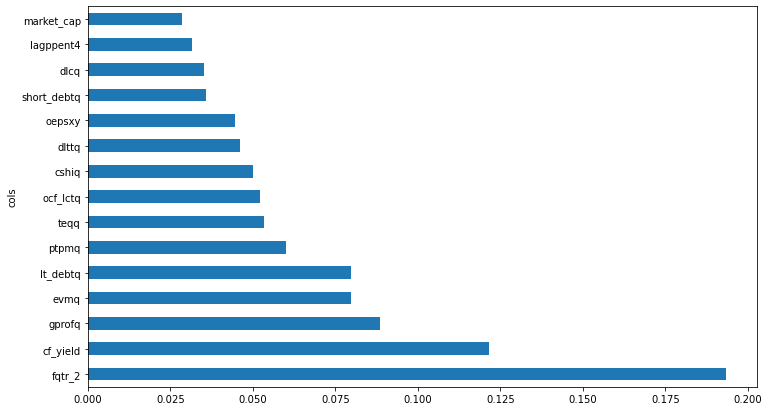

In [34]:
plot_fi(features);

#### We are left with a much smaller set of features

In [35]:
len(features['cols'].values)

15

### We cut down the training and validation data sets to only include the relevant features and retrain the tree on the reduced data set

In [36]:
train_1 = train_1[features['cols'].values]

In [37]:
t_clf.fit(train_1,y_1)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=600, random_state=123)

In [38]:
t_clf.score(train_1,y_1)

0.5562352641305041

In [39]:
valid = valid[features['cols'].values]

In [40]:
t_clf.score(valid,y_valid)

0.44623990055935364

In [41]:
pred_valid = t_clf.predict(valid)

In [42]:
confusion_matrix(y_valid,pred_valid)

array([[103,   0, 725],
       [ 13,   0,  86],
       [ 67,   0, 615]])

## We are really only interested in how much return the strategy generates over the validation period

In [43]:
(pred_valid * df_valid['next_period_return']).sum()

-8.868565000000022

### We define the Profit Importance of a feature by how much removing the feature affects the profit (positivly or negatively). By scrambling the feature column we get a column which should have to effect on the profit and we compute the profit with the scrambled column. Because the scrambling is random we use 100 random permutations and take the average.

Essentially takes out the column (doesn't need to re-run many times).

In [44]:
def profit_importance(t,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = t.predict(X)
            profit.append((prediction * rets).sum())
    return profit

In [45]:
def tree_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [46]:
pi = tree_profit_importance(t_clf,valid,df_valid['next_period_return'])
pi

,cols,pi_imp
3,evmq,-13.927877
4,lt_debtq,-13.196193
0,fqtr_2,-10.957913
1,cf_yield,-10.419663
12,dlcq,-9.380279
11,short_debtq,-9.173265
5,ptpmq,-8.868565
6,teqq,-8.868565
7,ocf_lctq,-8.868565
8,cshiq,-8.868565


## We now remove the features one at a time from the bottom of the profit importance list and recompute the profit. At each step we rettain the tree and remove features that may become irrelevant. We then compute a new profit importance list and remove the last item etc. The features are very interdependent so removing a feature can greatly affect the profit importances of the remaining features

In [47]:
profits = []
feat=[]
train = train_1.copy()
validation = valid.copy()
while len(train.columns)>2:
    # Removes a feature, retrains...
    t_clf.fit(train,y_1)
    pi = tree_profit_importance(t_clf,validation,valid_stock_returns)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    
    train.drop(col_to_drop,axis=1,inplace=True)
    validation.drop(col_to_drop,axis=1,inplace=True)
    
    t_clf.fit(train,y_1)
    fi = tree_feat_importance(t_clf,train)
    features = fi[(fi['feat_imp'] > 0.00)]
    
    train = train[features['cols'].values]
    validation = validation[features['cols'].values]
    
    t_clf.fit(train,y_1)
    pred_valid = t_clf.predict(validation)
    profits.append((pred_valid * df_valid['next_period_return']).sum())
    feat.append(features['cols'].values)
    

### We plot the profits for the steps and find the step where the profit is maximal and take the corresponding set of features as the optimal feature set

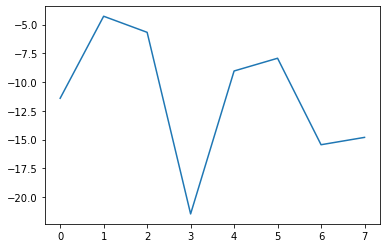

In [48]:
plt.plot(profits);

In [49]:
n = np.argmax(profits)
max_profits = profits[n]
optim_feats = feat[n]

In [50]:
print(max_profits)
print(optim_feats)

-4.274410999999988
['cf_yield' 'lt_debtq' 'market_cap' 'evmq' 'ocf_lctq' 'dlcq' 'ptpmq'
 'short_debtq' 'cshiq']


### We restrict the traing set to the optimal features and retrain the tree on the reduces data set

In [51]:
train_1_optim = train_1[optim_feats]
valid_optim = valid[optim_feats]

t_clf.fit(train_1_optim,y_1)
pred_valid_tree = t_clf.predict(valid_optim)
(pred_valid_tree * df_valid['next_period_return']).sum()

-4.274410999999988

## How well does it do on the test set?

In [52]:
train_2_tree = train_2[optim_feats]
test_tree = test[optim_feats]
t_clf.fit(train_2_tree,y_2)
pred_test_tree = t_clf.predict(test_tree)
(pred_test_tree * df_test['next_period_return']).sum()

0.20564400000000482

## If we were 100% correct on the validation set we would get this profit

In [53]:
(y_valid * df_valid['pred_rel_return']).sum()

167.6089899999999

## A totally random strategy where we randomly decide whether to buy or sell

In [54]:
m = len(df_test['next_period_return'])

In [58]:
random_predictions = []
for _ in range(1000):
    pred_random = np.random.choice([-1,0,1],m)
    random_predictions.append((pred_random * df_test['next_period_return']).sum())
    

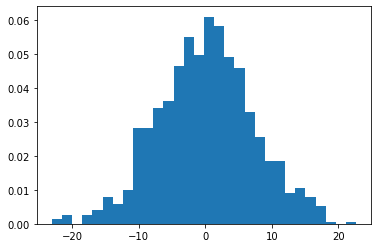

In [59]:
plt.hist(random_predictions,bins=30,density=True);

In [60]:
np.mean(random_predictions)

0.09014800399999813

## Now we run this strategy over the whole period and se how it performs

Walking forward

In [61]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [62]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [63]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [64]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

`training_labels` array of arrays; length = number of training frames

In [65]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [66]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [67]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)-1):
        t_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = t_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

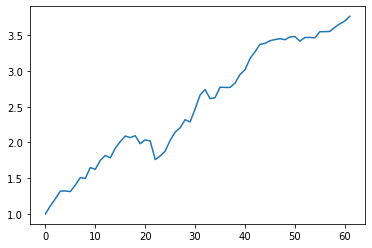

In [68]:
plt.plot(x);

## Compared to a buy-and-hold of SPY

In [ ]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-04-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

In [ ]:
SPY.plot();

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
print('Strategy Sharpe Ratio: ',strategy_mean_ret/strategy_std)

In [ ]:
spy_mean_ret = (SPY['spy_cum_ret'] - 1).diff().mean()
spy_std = (SPY['spy_cum_ret'] - 1).diff().std()
print('SPY Sharpe Ratio: ',spy_mean_ret/spy_std)

### Total Returns

In [ ]:
x[-1]

In [ ]:
SPY['spy_cum_ret'][-1]

### Computing the (quarterly) $\alpha$ of the strategy

In [ ]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [ ]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

In [ ]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

In [ ]:
alpha = np.mean(residual_ret)
alpha